# Data Science for Marketing Analytics
by: **Bima Putra Pratama**
_____

Pada sesi kali ini kita akan melakukan prediksi terhadap customer value yang didapatkan pada akhir tahun 2011 berdasarkan data di periode 2010. Sehingga kita bisa melakukan proyeksi berapa nilai yang akan kita terima pada tahun selanjutnya. 

Fokus utama pada sesi ini adalah kita dapat menerapkan salah satu teknik supervised mesin learning linear regression untuk memprediksi suatu nilai.

Library yang di gunakan adalah:

In [131]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline
pd.set_option('display.max_columns', None)
sns.set(style="darkgrid")


# Define color for the seaborn visuals
C_Blue = '#2CBDFE'
C_Green = '#47DBCD'
C_Pink = '#F3A0F2'
C_Purple = '#9D2EC5'
C_Violet = '#661D98'
C_Amber = '#F5B14C'

color_list = [C_Blue, C_Green, C_Amber, C_Pink,
              C_Violet]

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

## 1. Import Data

In [132]:
seg_10 = pd.read_csv('output/user_segment_10.csv')
seg_11 = pd.read_csv('output/user_segment_11.csv')

In [133]:
print('\n----- segment 2010 -----\n')
display(seg_10.head())

print('\n----- segment 2011 -----\n')
display(seg_11.head())


----- segment 2010 -----



,Customer ID,Recency,Frequency,Monetary,cluster,segments,score
0,12346,167,2,84.680000,4,Loss,1
1,12608,42,1,415.790000,0,Potential Loss,2
2,12745,65,2,361.925000,0,Potential Loss,2
3,12746,178,1,254.550000,0,Potential Loss,2
4,12747,26,13,311.425385,2,Loyalist,5



----- segment 2011 -----



,Customer ID,Recency,Frequency,Monetary,cluster,segments,score
0,12346,327,1,77183.600000,0,Potential Loss,1
1,12747,24,9,387.748889,2,Churn,3
2,12748,6,171,164.511228,4,Loyalist,5
3,12749,24,5,808.176000,2,Churn,3
4,12820,46,4,235.585000,2,Churn,3


## 2. Pemrosesan Data

### Menghitung Customer Lifetime Values

In [134]:
# Nilai di tahun 2010
seg_10['total_sales']= seg_10['Monetary']*seg_10['Frequency']

# Nilai di tahun 2011
seg_11['total_sales']= seg_11['Monetary']*seg_11['Frequency']

# Mengambil Kolom total_sales di 2011
seg_11 = seg_11[['Customer ID', 'total_sales']]

In [135]:
seg_11.head()

,Customer ID,total_sales
0,12346,77183.60
1,12747,3489.74
2,12748,28131.42
3,12749,4040.88
4,12820,942.34


In [136]:
# Menggabungkan data
seg_model = seg_10.merge(seg_11, how = 'left', on = 'Customer ID')

seg_model.head()

,Customer ID,Recency,Frequency,Monetary,cluster,segments,score,total_sales_x,total_sales_y
0,12346,167,2,84.680000,4,Loss,1,169.36,77183.60
1,12608,42,1,415.790000,0,Potential Loss,2,415.79,NaN
2,12745,65,2,361.925000,0,Potential Loss,2,723.85,NaN
3,12746,178,1,254.550000,0,Potential Loss,2,254.55,NaN
4,12747,26,13,311.425385,2,Loyalist,5,4048.53,3489.74


In [139]:
# Mengganti Null dengan nilai 0
seg_model['total_sales_y'].fillna(0, inplace = True)

# Menghitung Total Sales
seg_model['total_sales'] = seg_model['total_sales_x']+seg_model['total_sales_y']

seg_model.set_index('Customer ID', inplace = True)

seg_model = seg_model[['Recency','Frequency','Monetary','score','total_sales']]

In [140]:
seg_model.describe().round(2)

,Recency,Frequency,Monetary,score,total_sales
count,3844.00,3844.00,3844.00,3844.00,3844.00
mean,92.83,4.18,354.52,2.79,3132.99
std,89.69,6.87,425.25,1.31,12472.43
min,1.00,1.00,1.55,1.00,3.75
25%,21.00,1.00,177.12,2.00,405.66
50%,58.00,2.00,279.81,3.00,1056.62
75%,143.00,5.00,408.74,4.00,2740.14
max,344.00,140.00,11880.84,5.00,539981.30


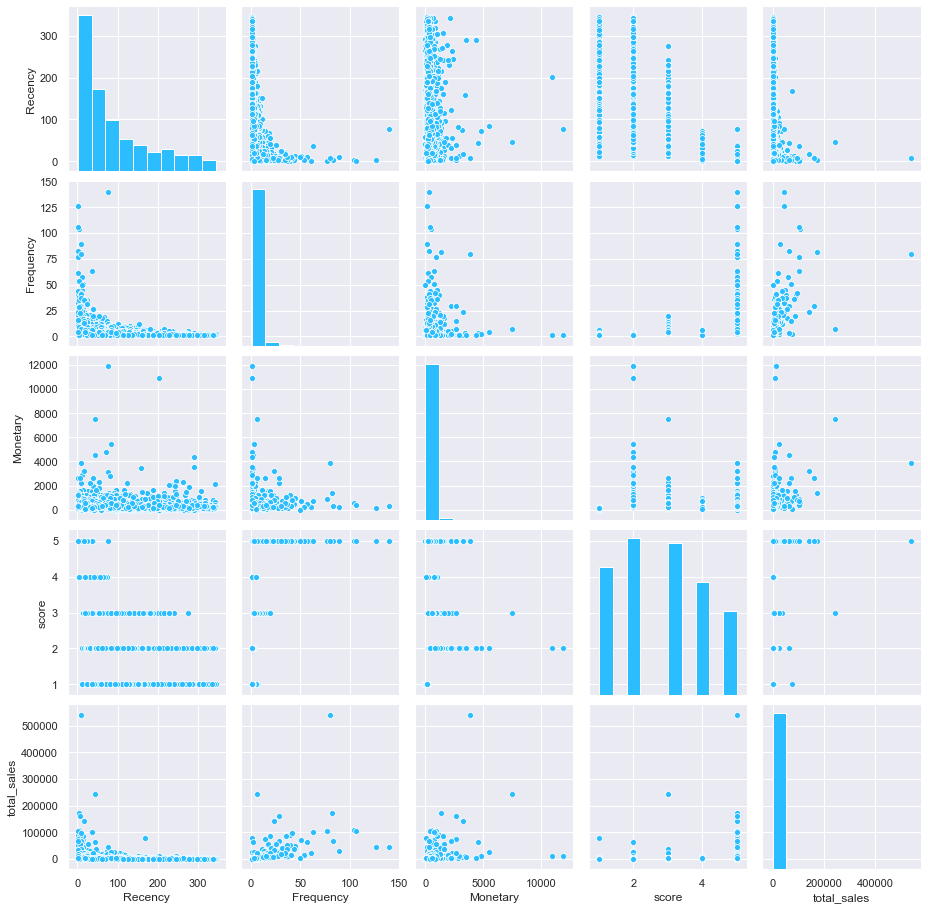

In [142]:
# Melihat distribrusi dan korelasi data
sns.pairplot(seg_model)

#### Identifikasi dan menghapus outliers

Dari hasil pairplot sebelum nya kita dapat mengidentifikasi bahwa terdapat outliers di data kita. Sehingga kita perlu menghilangkan outliers tersebut sebelum kita melakukan permodelan

In [143]:
# Menghitung Q1
Q1 = seg_model.quantile(0.25)
    
# Menghitung Q2
Q3 = seg_model.quantile(0.75)
    
# Menghitung Interquertile range
IQR = Q3 - Q1

df_cleaned = seg_model[~((seg_model < (Q1 - 1.5 * IQR)) |(seg_model > (Q3 + 1.5 * IQR))).any(axis=1)]

df_cleaned

,Recency,Frequency,Monetary,score,total_sales
Customer ID,,,,,
12608,42,1,415.790000,2,415.79
12745,65,2,361.925000,2,723.85
12746,178,1,254.550000,2,254.55
12777,125,1,519.450000,2,519.45
12819,156,1,540.520000,2,540.52
...,...,...,...,...,...
18281,37,1,120.320000,1,201.14
18283,20,6,106.961667,4,2730.70
18284,246,1,411.680000,2,411.68


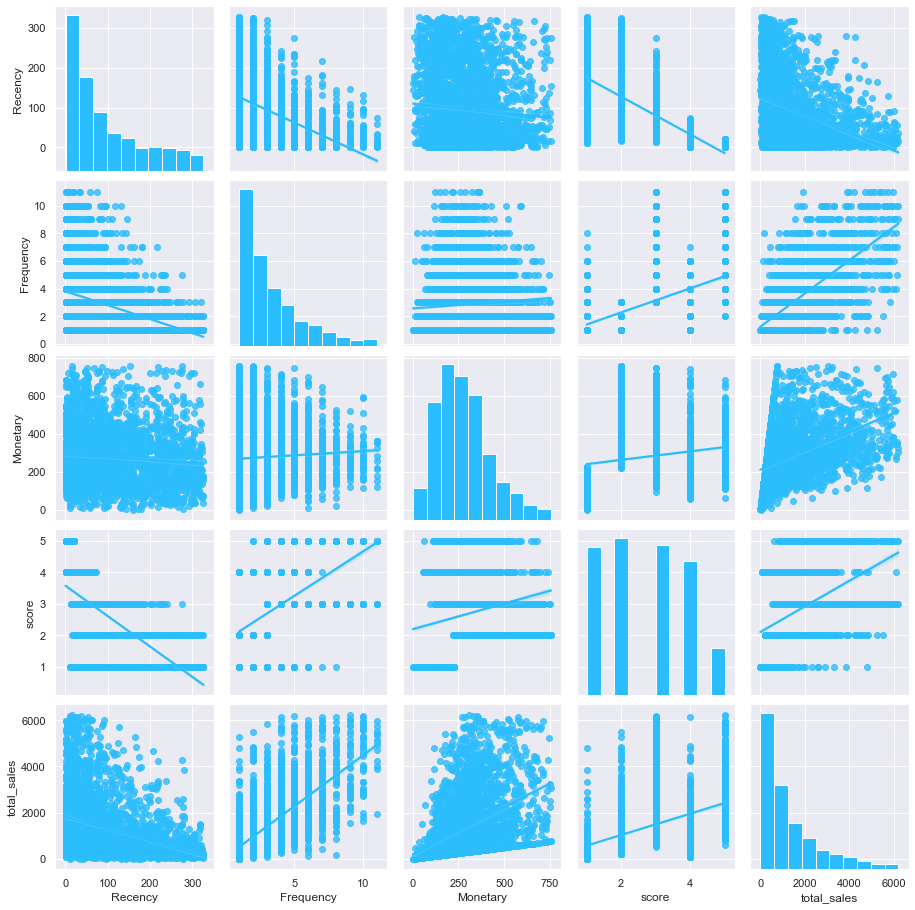

In [144]:
sns.pairplot(df_cleaned, kind = 'reg')

Setelah kita mebersihkan outliers, Kita akan melihat nilai korelasi antar variable yang kita punya. Suatu variable dikatakan memiliki korelasi yang kuat apabila memiliki nilai korelasi lebih dari 0.7

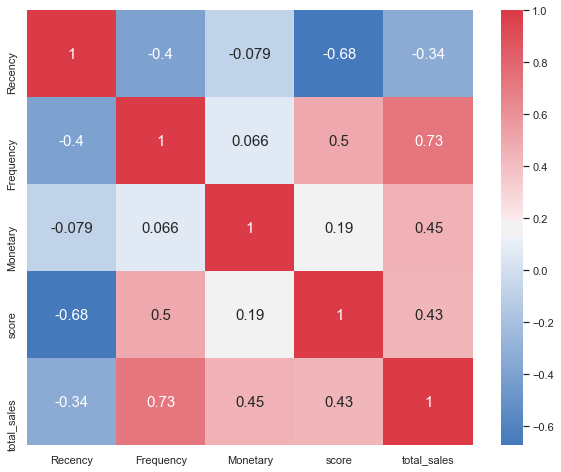

In [116]:
# Create a pairplot for Actual Values
df_corr = df_cleaned
corr = df_corr.corr()

# Set color map
cmap = sns.diverging_palette(250, 10, as_cmap=True)

# Plot heatmap
plt.subplots(figsize=(10,8))
ax = sns.heatmap(corr,annot=True,cmap=cmap,annot_kws={"size":15})

# Fixing half cut in plot
# bottom, top = ax.get_ylim()
# ax.set_ylim(bottom + 0.5, top - 0.5)

### Modelling

Setelah data siap saatnya kita melakukan linear regresi untuk memprediksi total sales dari variable yang kita miliki.

Pertama kita memisahkan target dan predictor variable

In [268]:
# Persiapan Data
X = df_cleaned[['Recency','Frequency','Monetary','score']]
Y = df_cleaned['total_sales']

Lalu kita memisahkan data untuk training dan test data dengan komposisi 80% dan 20%

In [244]:
# Split Data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=99)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(2580, 4)
(646, 4)
(2580, 1)
(646, 1)


In [245]:
# Training dan Testing Model

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [246]:
coeff_df = pd.DataFrame(lin_model.coef_.T, X_train.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
Recency,-0.706576
Frequency,416.272538
Monetary,3.650417
score,-19.668766


In [247]:
lin_model.intercept_

-756.5161839009268

In [248]:
# model evaluation for training set
y_train_predict = lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict)))
r2 = r2_score(y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = lin_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_test_predict)))
r2 = r2_score(y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 737.3178386543676
R2 score is 0.6911821859274843


The model performance for testing set
--------------------------------------
RMSE is 744.7841434896759
R2 score is 0.6982164541878446


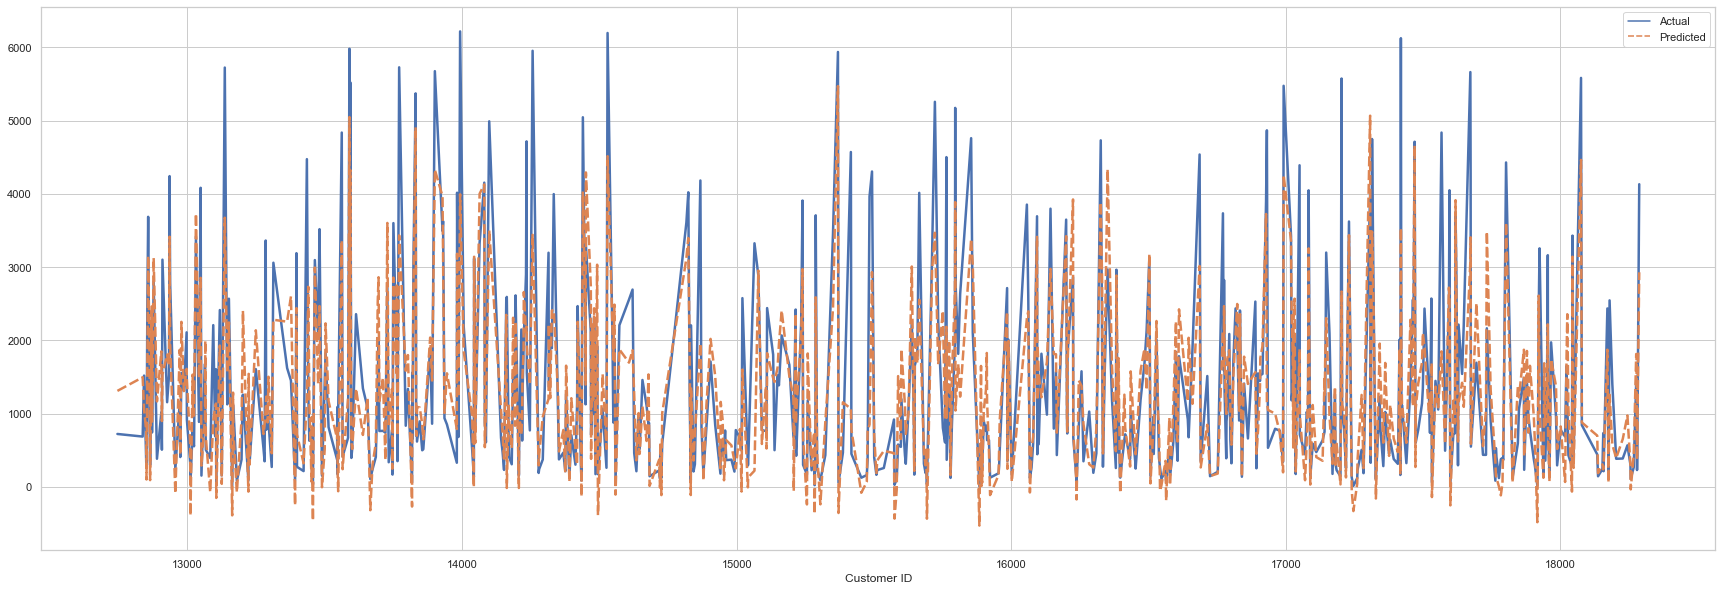

In [266]:
plt.subplots(figsize=(30,10))
sns.lineplot(data=df, linewidth=2.5)
